In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path="/content/drive/MyDrive/Research/cods_comad_plots/SDC/dataset_5/"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [4]:
def create_data(n_patch, n_points, true_points, test_data=False, normalize=True, rseed=12):
  '''
  Arguments:
  n_patch : number of patches (n_patch x n_patch)
  n_points : number of points per patch
  true_points: number of points for true patch cluster
  normalize: if True then return normalized data

  '''
  np.random.seed(rseed)
  x_min = 0
  x_max = 1

  y_min = 0 
  y_max = 1
  csize = n_points

  X = []
  Y = []
  k = 2 
  # 10x10 patch of clusters
  for i in range(n_patch):
    for j in range(n_patch):
      if (i == 3 and j == 0):
        #print(x_min,x_max,y_min,y_max)
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(true_points,2)))
        labels = np.zeros(true_points)
        Y.append(labels)
      elif (i==3 and j==1):
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(true_points,2)))
        labels = np.ones(true_points)
        Y.append(labels)
      else:
        X.append(np.random.uniform(low=[x_min,y_min],high=[x_max,y_max],size=(csize,2)))
        #labels = np.random.randint(0,2,csize)
        labels = np.ones(csize)*int(k)
        Y.append(labels)
        k = k+1
      x_min += 1.5
      x_max += 1.5
    x_min = 0
    x_max = 1
    y_min += 1.5
    y_max += 1.5
  X = np.concatenate(X,axis=0)
  Y = np.concatenate(Y,axis=0)

  if normalize ==True:
    X = ( X - np.mean(X,axis =0 ) ) / np.std(X)
  idx = np.logical_or(Y==0,Y==1)
  # print("no of corrupted data points",sum(~idx))

  return X, Y

In [5]:
x,y = create_data(n_patch = 7, n_points= 30, true_points = 30, test_data=False, normalize=True, rseed=12)

In [6]:
np.unique(y)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48.])

In [7]:
np.random.seed(12)
# y = np.random.randint(0,10,5000)
idx= []
for i in range(49):
    print(i,sum(y==i))
    idx.append(y==i)

0 30
1 30
2 30
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 30
20 30
21 30
22 30
23 30
24 30
25 30
26 30
27 30
28 30
29 30
30 30
31 30
32 30
33 30
34 30
35 30
36 30
37 30
38 30
39 30
40 30
41 30
42 30
43 30
44 30
45 30
46 30
47 30
48 30


In [8]:
color = ['blue','orange','brown']

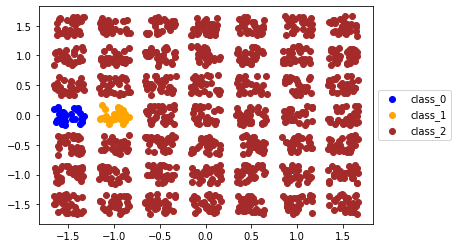

In [9]:
for i in range(49):
  if(i==0):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[0])
  elif (i==1):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[1])
  elif (i==2):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[2])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1], c = color[2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
bg_idx = []
for i in range(2,49,1):
  bg_idx.append(np.where(idx[i] == True)[0])
# bg_idx = [ np.where(idx[3] == True)[0], 
#           np.where(idx[4] == True)[0], 
#           np.where(idx[5] == True)[0],
#           np.where(idx[6] == True)[0], 
#           np.where(idx[7] == True)[0], 
#           np.where(idx[8] == True)[0],
#           np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(1410,)

In [11]:
np.unique(bg_idx).shape

(1410,)

In [12]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [13]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[ 4.50388348e-17, -3.30704731e-17]]),
 array([[-0.0527468 , -0.00040089]]))

In [14]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [15]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[1.01448168, 0.97953861]]))

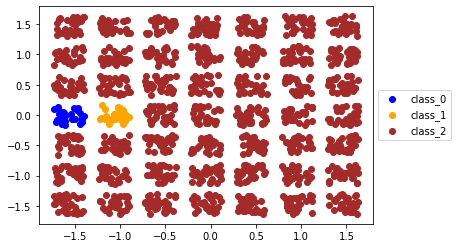

In [16]:
for i in range(49):
  if(i==0):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[0])
  elif (i==1):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[1])
  elif (i==2):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i), c = color[2])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1], c = color[2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [17]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,49)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 4 present at 0
background 5 present at 1
background 24 present at 2
background 7 present at 3
background 27 present at 4
background 13 present at 5
foreground 1 present at 6
background 2 present at 7
background 42 present at 8
(9, 2)
1 6


In [18]:
a.shape

(9, 2)

In [19]:
desired_num = 3000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,49)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(a)
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [20]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [21]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(3000, array([[-1.42771166, -1.62391778],
        [-0.04282785, -1.49612804],
        [-0.45741618, -0.85572753],
        [-0.64535272, -0.10283582],
        [-0.13184325,  0.96870073],
        [-1.6183973 ,  0.03188545],
        [ 0.97788975, -0.13936291],
        [ 1.05366461, -0.99089996],
        [-1.06496041, -1.34451686]]))

In [22]:
mosaic_list_of_images_reshaped = np.reshape(mosaic_list_of_images, (3000,9,2))
mean_train = np.mean(mosaic_list_of_images_reshaped[0:1500], axis=0, keepdims= True)
print(mean_train.shape, mean_train)
std_train = np.std(mosaic_list_of_images_reshaped[0:1500], axis=0, keepdims= True)
print(std_train.shape, std_train)

(1, 9, 2) [[[-0.12522238  0.02484027]
  [-0.17217382 -0.004048  ]
  [-0.17240485 -0.06976667]
  [-0.15785976 -0.00488011]
  [-0.127034   -0.00935079]
  [-0.11457274  0.00144386]
  [-0.14482529 -0.02110999]
  [-0.11965883 -0.01602514]
  [-0.14400433 -0.00973536]]]
(1, 9, 2) [[[1.03643134 0.9314066 ]
  [1.03572911 0.95261401]
  [1.04037655 0.94864234]
  [1.03823645 0.93540081]
  [1.0273509  0.92575359]
  [1.01941163 0.94500788]
  [1.03895991 0.95128579]
  [1.04134529 0.92761568]
  [1.01186294 0.94467271]]]


In [23]:
mosaic_list_of_images = ( mosaic_list_of_images_reshaped - mean_train ) / std_train

In [24]:
print(np.mean(mosaic_list_of_images[0:1500], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[0:1500], axis=0, keepdims= True))

[[[ 1.52100554e-16  3.33159426e-17]
  [-4.48530102e-17 -2.72374715e-17]
  [ 1.13242749e-16  3.37507799e-17]
  [ 2.18195832e-16  1.95399252e-17]
  [ 1.50657264e-16 -3.21224528e-17]
  [-4.76655752e-17  2.30741352e-17]
  [-1.36372395e-16 -7.99360578e-18]
  [ 5.24765416e-17  8.99280650e-17]
  [ 6.55771733e-17  7.54951657e-18]]]
[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]


In [25]:
print(np.mean(mosaic_list_of_images[1500:3000], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[1500:3000], axis=0, keepdims= True))

[[[-0.02832369 -0.03123986]
  [ 0.03925054 -0.05429414]
  [ 0.01766986  0.05521203]
  [ 0.00208788  0.01431834]
  [ 0.00381965  0.04373831]
  [-0.03228485 -0.01901092]
  [-0.00037231  0.05405353]
  [-0.01194032  0.02877645]
  [ 0.03292435  0.01633747]]]
[[[1.00719858 1.01249602]
  [1.00629158 0.98686751]
  [0.98844152 0.99422888]
  [1.00919027 1.01264973]
  [1.00727965 1.02079872]
  [1.01258466 1.00933853]
  [0.99404152 0.9855528 ]
  [0.99617552 1.02133476]
  [1.01966777 0.99892908]]]


In [26]:
mosaic_list_of_images.shape

(3000, 9, 2)

In [27]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(3000, array([[-1.25670581, -1.77018077],
        [ 0.12488398, -1.56630075],
        [-0.27395017, -0.82851126],
        [-0.46953944, -0.10472058],
        [-0.00468121,  1.05649227],
        [-1.47518875,  0.03221306],
        [ 1.0806144 , -0.12430851],
        [ 1.12673813, -1.0509469 ],
        [-0.91015892, -1.41295656]]))

In [28]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [29]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1500], mosaic_label[0:1500] , fore_idx[0:1500])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [30]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1500:3000], mosaic_label[1500:3000] , fore_idx[1500:3000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [31]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(2, 64, bias=False)
    self.fc2 = nn.Linear(64, 2, bias=False)

    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)

    # self.fc3 = nn.Linear(10, 1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,2], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    # print(x.shape, z.shape)
    for i in range(9):
      # print(z[:,i].shape)
      # print(self.helper(z[:,i])[:,0].shape)
      x[:,i] = self.helper(z[:,i])[:,0]
    # print(x.shape, z.shape)
    x = F.softmax(x,dim=1)
    # print(x.shape, z.shape)
    # x1 = x[:,0]
    # print(torch.mul(x[:,0],z[:,0]).shape)

    for i in range(9):            
      # x1 = x[:,i]          
      y = y + torch.mul(x[:,i,None],z[:,i])

    # print(x.shape, y.shape)
    return x, y
    
  def helper(self, x):
    x = x.view(-1, 2)
    x = F.relu(self.fc1(x))
    x = (self.fc2(x))

    return x

In [32]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 64)
    self.fc2 = nn.Linear(64, 2)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)  
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)  

  def forward(self, x):
    x = x.view(-1, 2)
    x = F.relu(self.fc1(x))
    x = (self.fc2(x))
    return x

In [33]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [34]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to("cuda")

In [35]:
focus_net.fc1.weight.shape,focus_net.fc2.weight.shape

(torch.Size([64, 2]), torch.Size([2, 64]))

In [36]:
focus_net.fc1.weight.data[32:,:] = focus_net.fc1.weight.data[:32,:] #torch.nn.Parameter(torch.tensor([last_layer]) )
focus_net.fc1.weight[:32,:], focus_net.fc1.weight[32:,:] 

(tensor([[ 0.1384,  0.4146],
         [-0.0645, -0.1379],
         [-0.3038,  0.0789],
         [ 0.1507,  0.0908],
         [-0.0058, -0.2285],
         [-0.1611, -0.0671],
         [ 0.1167,  0.4307],
         [ 0.0478, -0.0061],
         [ 0.2542,  0.2705],
         [-0.2770, -0.0366],
         [-0.1206,  0.0265],
         [-0.3176,  0.1291],
         [-0.0547, -0.3380],
         [-0.3228,  0.0480],
         [-0.2284,  0.0970],
         [ 0.0121, -0.4168],
         [ 0.0233, -0.1872],
         [ 0.3466, -0.2574],
         [ 0.0748, -0.2478],
         [ 0.0343,  0.0253],
         [-0.0777,  0.1383],
         [ 0.1298,  0.0668],
         [-0.2536, -0.0570],
         [-0.1274,  0.2983],
         [ 0.0276, -0.0747],
         [ 0.0765, -0.0231],
         [ 0.0252,  0.0900],
         [ 0.1418,  0.1092],
         [ 0.1134, -0.0367],
         [ 0.0477, -0.2083],
         [ 0.1170, -0.0264],
         [-0.0757,  0.2156]], device='cuda:0', dtype=torch.float64,
        grad_fn=<SliceBackward>),

In [37]:
focus_net.fc2.weight.data[:,32:] = -focus_net.fc2.weight.data[:,:32] #torch.nn.Parameter(torch.tensor([last_layer]) )
focus_net.fc2.weight

Parameter containing:
tensor([[ 0.2062, -0.2611,  0.1228,  0.0316,  0.0750, -0.1061,  0.0105, -0.0106,
         -0.0865, -0.1196,  0.2246, -0.1084, -0.1762,  0.2709, -0.2584, -0.4090,
          0.0782, -0.1009,  0.0815,  0.1414, -0.1023,  0.1626, -0.2201,  0.1488,
          0.0492,  0.1403, -0.1175, -0.1718,  0.0779,  0.0020, -0.1754, -0.2662,
         -0.2062,  0.2611, -0.1228, -0.0316, -0.0750,  0.1061, -0.0105,  0.0106,
          0.0865,  0.1196, -0.2246,  0.1084,  0.1762, -0.2709,  0.2584,  0.4090,
         -0.0782,  0.1009, -0.0815, -0.1414,  0.1023, -0.1626,  0.2201, -0.1488,
         -0.0492, -0.1403,  0.1175,  0.1718, -0.0779, -0.0020,  0.1754,  0.2662],
        [ 0.0033,  0.2476,  0.1298, -0.0482,  0.0759, -0.1460, -0.1803,  0.0187,
          0.0924, -0.1501, -0.2879, -0.1247,  0.2290, -0.3005, -0.1920,  0.2111,
          0.0705, -0.0427,  0.2484,  0.0786, -0.2203, -0.1742, -0.2197,  0.2436,
         -0.1663,  0.0044,  0.3051,  0.1958, -0.1969,  0.0720,  0.0028, -0.1438,
     

In [38]:
focus_net = focus_net.double().to("cuda")

In [39]:
focus_net.helper( torch.randn((1,9,2)).double().to("cuda") )

tensor([[ 4.6005e-19, -7.9962e-18],
        [-4.3588e-19,  1.7823e-18],
        [-1.1583e-17,  3.8308e-18],
        [ 6.5257e-18, -7.4685e-18],
        [ 1.1528e-18, -5.5866e-19],
        [ 1.5463e-17,  1.0439e-18],
        [ 4.1949e-18,  4.3105e-18],
        [ 3.1580e-18, -8.6399e-18],
        [ 2.8794e-17, -1.0282e-17]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MmBackward>)

In [40]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.01 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

In [41]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [42]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)
    # print(predicted.shape)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      # print(focus, fore_idx[j], predicted[j])
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 1500 train images: 48 %
total correct 727
total train set images 1500
focus_true_pred_true 88 =============> FTPT : 5 %
focus_false_pred_true 639 =============> FFPT : 42 %
focus_true_pred_false 87 =============> FTPF : 5 %
focus_false_pred_false 686 =============> FFPF : 45 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1500
1500


In [43]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 1500 test images: 51 %
total correct 778
total train set images 1500
focus_true_pred_true 88 =============> FTPT : 5 %
focus_false_pred_true 690 =============> FFPT : 46 %
focus_true_pred_false 68 =============> FTPF : 4 %
focus_false_pred_false 654 =============> FFPF : 43 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1500


In [44]:
nos_epochs = 1000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 3
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.001):
      break;

  if epoch % 5 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    # print("="*20)
    # print("Train FTPT : ", col4)
    # print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # print("Test FTPT : ", col10)
    # print("Test FFPT : ", col11)
    # print("="*20)
    
print('Finished Training')

[1,     3] loss: 0.694
[1,     6] loss: 0.684
[2,     3] loss: 0.681
[2,     6] loss: 0.667
[3,     3] loss: 0.649
[3,     6] loss: 0.628
[4,     3] loss: 0.597
[4,     6] loss: 0.559
[5,     3] loss: 0.515
[5,     6] loss: 0.462
[6,     3] loss: 0.417
[6,     6] loss: 0.356
[7,     3] loss: 0.307
[7,     6] loss: 0.272
[8,     3] loss: 0.236
[8,     6] loss: 0.204
[9,     3] loss: 0.174
[9,     6] loss: 0.155
[10,     3] loss: 0.145
[10,     6] loss: 0.119
[11,     3] loss: 0.104
[11,     6] loss: 0.104
[12,     3] loss: 0.095
[12,     6] loss: 0.085
[13,     3] loss: 0.081
[13,     6] loss: 0.075
[14,     3] loss: 0.080
[14,     6] loss: 0.057
[15,     3] loss: 0.060
[15,     6] loss: 0.062
[16,     3] loss: 0.059
[16,     6] loss: 0.051
[17,     3] loss: 0.053
[17,     6] loss: 0.047
[18,     3] loss: 0.047
[18,     6] loss: 0.048
[19,     3] loss: 0.047
[19,     6] loss: 0.050
[20,     3] loss: 0.048
[20,     6] loss: 0.038
[21,     3] loss: 0.042
[21,     6] loss: 0.038
[22,     3

In [45]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [46]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [47]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [48]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1500,88,639,87,686
1,1,0,1500,205,608,189,498
2,6,1038,462,1168,133,90,109
3,11,1423,77,1336,133,22,9
4,16,1472,28,1386,101,8,5
5,21,1479,21,1389,100,8,3
6,26,1480,20,1388,104,6,2
7,31,1486,14,1398,96,3,3
8,36,1484,16,1399,98,2,1
9,41,1486,14,1384,112,3,1


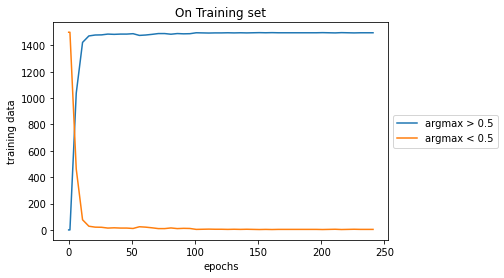

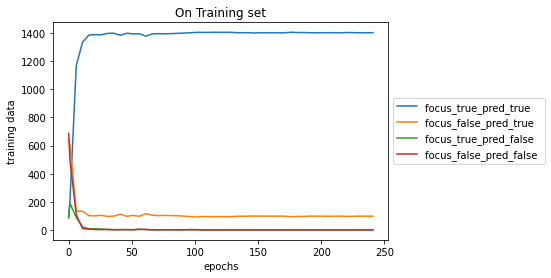

In [49]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

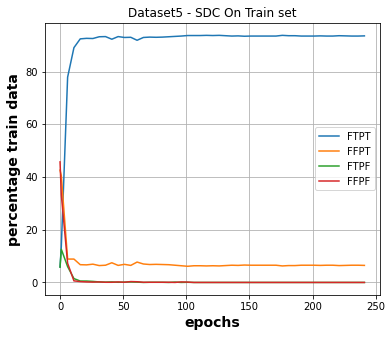

In [50]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/15, label ="FTPT")
plt.plot(col1,np.array(col5)/15, label ="FFPT")
plt.plot(col1,np.array(col6)/15, label ="FTPF")
plt.plot(col1,np.array(col7)/15, label ="FFPF")
plt.title("Dataset5 - SDC On Train set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"ds5_train.png", bbox_inches="tight")
plt.savefig(path+"ds5_train.pdf", bbox_inches="tight")
plt.savefig("ds5_train.png", bbox_inches="tight")
plt.savefig("ds5_train.pdf", bbox_inches="tight")
plt.show()

In [51]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1500,88,690,68,654
1,1,0,1500,497,365,207,431
2,6,1161,339,1226,137,55,82
3,11,1443,57,1351,117,27,5
4,16,1475,25,1389,98,10,3
5,21,1484,16,1398,91,7,4
6,26,1488,12,1406,89,4,1
7,31,1488,12,1392,103,3,2
8,36,1493,7,1403,94,2,1
9,41,1491,9,1403,94,1,2


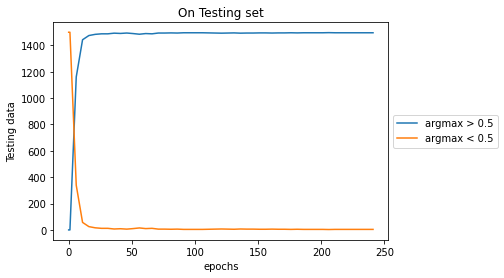

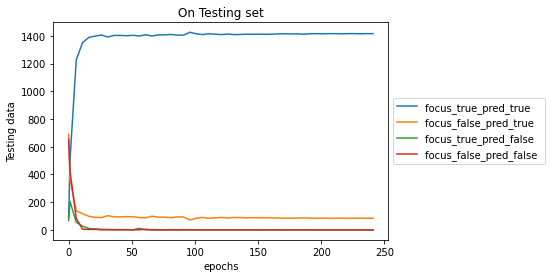

In [52]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

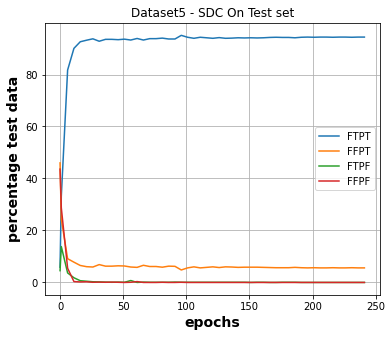

In [53]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/15, label ="FTPT")
plt.plot(col1,np.array(col11)/15, label ="FFPT")
plt.plot(col1,np.array(col12)/15, label ="FTPF")
plt.plot(col1,np.array(col13)/15, label ="FFPF")
plt.title("Dataset5 - SDC On Test set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"ds5_test.png", bbox_inches="tight")
plt.savefig(path+"ds5_test.pdf", bbox_inches="tight")
plt.savefig("ds5_test.png", bbox_inches="tight")
plt.savefig("ds5_test.pdf", bbox_inches="tight")
plt.show()

In [54]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1500 train images: 100 %
total correct 1500
total train set images 1500
focus_true_pred_true 1403 =============> FTPT : 93 %
focus_false_pred_true 97 =============> FFPT : 6 %
focus_true_pred_false 0 =============> FTPF : 0 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  1497
argmax_less_than_half ==================>  3


In [55]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1500 test images: 100 %
total correct 1500
total train set images 1500
focus_true_pred_true 1416 =============> FTPT : 94 %
focus_false_pred_true 84 =============> FFPT : 5 %
focus_true_pred_false 0 =============> FTPF : 0 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  1497
argmax_less_than_half ==================>  3


In [56]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1500 train images: 100 %
total correct 1500
total train set images 1500


In [57]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1500 test images: 100 %
total correct 1500
total train set images 1500
